In [3]:
import matplotlib.pyplot as plt
import pandas as pd

## Plot training metrics

In [4]:
def plot_losses_vs_epoch(eval_losses, train_losses, title="Loss vs Epoch"):
    plt.figure(figsize=(6, 4))

    plt.plot(
        eval_losses["Step"][1:], eval_losses["Value"][1:], label="Eval Loss", c="r"
    )
    plt.plot(train_losses["Step"], train_losses["Value"], label="Train Loss", c="b")

    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()
    plt.figure()
    plt.show()

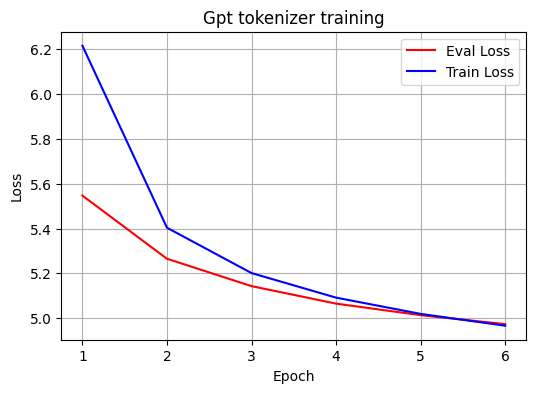

<Figure size 640x480 with 0 Axes>

In [5]:
gpt_training_loss = pd.read_csv("training_metrics/gpt_train.csv")
gpt_eval_loss = pd.read_csv("training_metrics/gpt_eval.csv")

plot_losses_vs_epoch(gpt_eval_loss, gpt_training_loss, title="Gpt tokenizer training")


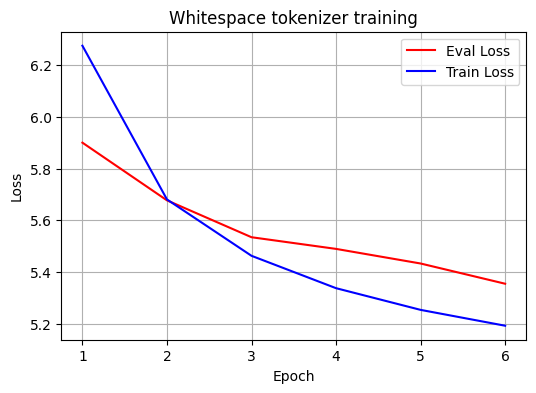

<Figure size 640x480 with 0 Axes>

In [7]:
gpt_training_loss = pd.read_csv("training_metrics/whitespace_train.csv")
gpt_eval_loss = pd.read_csv("training_metrics/whitespace_eval.csv")

plot_losses_vs_epoch(
    gpt_eval_loss, gpt_training_loss, title="Whitespace tokenizer training"
)


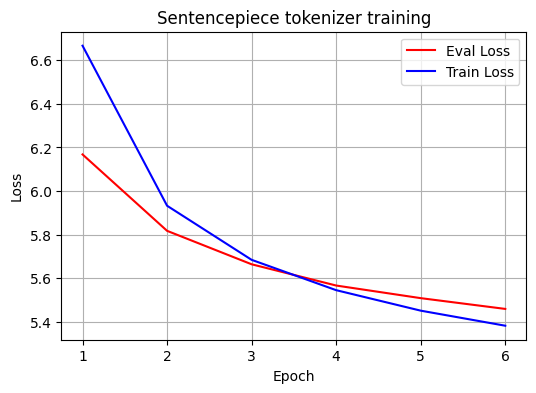

<Figure size 640x480 with 0 Axes>

In [ ]:
gpt_training_loss = pd.read_csv("training_metrics/sentencepiece_train.csv")
gpt_eval_loss = pd.read_csv("training_metrics/sentencepiece_eval.csv")

plot_losses_vs_epoch(
    gpt_eval_loss, gpt_training_loss, title="Sentencepiece tokenizer training"
)


## Models Comparision

In [ ]:
from transformers import AutoTokenizer
from transformer import TransformerLanguageModel
import torch
import torch.nn as nn
import torch.nn.functional as F
from whitespace import WhitespaceTokenizer
import re
import math


device = "cpu"


In [9]:
def load_tokenizer(load_path: str, custom_class=None):
    if custom_class is not None:
        tokenizer = custom_class.from_pretrained(load_path)
    else:
        tokenizer = AutoTokenizer.from_pretrained(load_path)
    print(f"Tokenizer loaded from: {load_path}")
    return tokenizer


def load_model(path: str, tokenizer):
    model = TransformerLanguageModel(
        vocab_size=tokenizer.vocab_size,
        embedding_dim=144,
        num_heads=4,
        blocks_count=4,
        seq_len=100,
        device=device,
    ).to(device)

    state_dict = torch.load(path, map_location=torch.device("cpu"))
    model.load_state_dict(state_dict)
    model.eval()
    print(f"Model loaded from {path}")
    return model


def load_text_data(path: str) -> str:
    with open(path, "r", encoding="utf-8") as file:
        return file.read()


In [146]:
eval_text = load_text_data("prepared_data/eval.txt")

In [11]:
gpt2_pl_tokenizer = load_tokenizer("tokenizers/gpt2-pl")
sentencepiece_tokenizer = load_tokenizer("tokenizers/sentencepiece")
whitespace_tokenizer = load_tokenizer(
    "tokenizers/whitespace", custom_class=WhitespaceTokenizer
)

Tokenizer loaded from: tokenizers/gpt2-pl


You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Tokenizer loaded from: tokenizers/sentencepiece
Loaded vocabulary from tokenizers/whitespace/vocab.json
Tokenizer loaded from: tokenizers/whitespace


In [ ]:
gpt2_model = load_model("models/gpt2pl/model_6.pt", gpt2_pl_tokenizer)
sentencepiece_model = load_model(
    "models/sentencepiece/model_6.pt", sentencepiece_tokenizer
)
whitespace_model = load_model("models/whitespace/model_6.pt", whitespace_tokenizer)


Tokenizer loaded from: tokenizers/gpt2-pl
Tokenizer loaded from: tokenizers/sentencepiece
Loaded vocabulary from tokenizers/whitespace/vocab.json
Tokenizer loaded from: tokenizers/whitespace
Model loaded from models/gpt2pl/model_6.pt
Model loaded from models/sentencepiece/model_6.pt
Model loaded from models/whitespace/model_6.pt


In [53]:
def word_level_perplexity(text, tokenizer, model, device="cpu"):
    model.eval()
    model.to(device)

    words = re.findall(r"\w+", text)
    words = words[:10000]
    total_words = len(words)

    log_probs_words = []

    for i, word in enumerate(words, start=1):
        word_tokens = tokenizer.encode(word)
        if len(word_tokens) == 0:
            continue

        if isinstance(tokenizer, WhitespaceTokenizer) and len(word_tokens) == 1:
            if i + 1 < total_words:
                next_word_tokens = tokenizer.encode(words[i + 1])
                if len(next_word_tokens) > 0:
                    input_ids = (
                        torch.tensor(word_tokens, dtype=torch.long)
                        .unsqueeze(0)
                        .to(device)
                    )
                    target_ids = (
                        torch.tensor(next_word_tokens, dtype=torch.long)
                        .unsqueeze(0)
                        .to(device)
                    )
                else:
                    continue
            else:
                continue
        else:
            if len(word_tokens) < 2:
                continue
            input_ids = (
                torch.tensor(word_tokens[:-1], dtype=torch.long).unsqueeze(0).to(device)
            )
            target_ids = (
                torch.tensor(word_tokens[1:], dtype=torch.long).unsqueeze(0).to(device)
            )

        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs[0]
            log_probs = F.log_softmax(logits, dim=-1)
            word_log_prob = (
                log_probs[0, torch.arange(len(target_ids[0])), target_ids[0]]
                .sum()
                .item()
            )
            log_probs_words.append(word_log_prob)

        if i % 1000 == 0 or i == total_words:
            avg_log_prob = sum(log_probs_words) / len(log_probs_words)
            print(
                f"Processed {i}/{total_words} words. "
                f"Average log-prob per word so far: {avg_log_prob:.4f}"
            )

    ppl = math.exp(-sum(log_probs_words) / len(log_probs_words))
    return ppl


In [61]:
def char_level_perplexity(text, tokenizer, model, device="cpu"):
    model.eval()
    model.to(device)

    chars = list(text)
    chars = chars[:10000]
    total_chars = len(chars)

    log_probs_chars = []

    for i, char in enumerate(chars, start=0):
        char_tokens = tokenizer.encode(char, add_special_tokens=False)
        char_tokens = [
            t if t < tokenizer.vocab_size else tokenizer.unk_token_id
            for t in char_tokens
        ]

        if len(char_tokens) == 0:
            continue
        elif len(char_tokens) == 1:
            if i < len(chars):
                # use next char token as target
                next_char_tokens = tokenizer.encode(chars[i], add_special_tokens=False)
                next_char_tokens = [
                    t if t < tokenizer.vocab_size else tokenizer.unk_token_id
                    for t in next_char_tokens
                ]
                if len(next_char_tokens) == 0:
                    continue
                input_ids = (
                    torch.tensor([char_tokens[0]], dtype=torch.long)
                    .unsqueeze(0)
                    .to(device)
                )
                target_ids = (
                    torch.tensor(next_char_tokens, dtype=torch.long)
                    .unsqueeze(0)
                    .to(device)
                )
            else:
                continue
        else:
            input_ids = (
                torch.tensor(char_tokens[:-1], dtype=torch.long).unsqueeze(0).to(device)
            )
            target_ids = (
                torch.tensor(char_tokens[1:], dtype=torch.long).unsqueeze(0).to(device)
            )

        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs[0]
            log_probs = F.log_softmax(logits, dim=-1)
            char_log_prob = (
                log_probs[0, torch.arange(len(target_ids[0])), target_ids[0]]
                .sum()
                .item()
            )
            log_probs_chars.append(char_log_prob)

        if (i + 1) % 1000 == 0 or (i + 1) == total_chars:
            avg_log_prob = sum(log_probs_chars) / len(log_probs_chars)
            print(
                f"Processed {i + 1}/{total_chars} chars. "
                f"Average log-prob per char so far: {avg_log_prob:.4f}"
            )

    if len(log_probs_chars) == 0:
        print("No characters processed! Returning inf perplexity.")
        return float("inf")

    ppl = math.exp(-sum(log_probs_chars) / len(log_probs_chars))
    return ppl

In [62]:
whitespace_word_ppl = word_level_perplexity(
    eval_text, whitespace_tokenizer, whitespace_model
)
gpt2pl_word_ppl = word_level_perplexity(eval_text, gpt2_pl_tokenizer, gpt2_model)
sentencepiece_word_ppl = word_level_perplexity(
    eval_text, sentencepiece_tokenizer, sentencepiece_model
)


print(f"GPT-pl word level perplexity: {gpt2pl_word_ppl}")
print(f"Whitespace word level perplexity: {whitespace_word_ppl}")
print(f"Sentencepiece word level perplexity: {sentencepiece_word_ppl}")

Processed 1000/10000 words. Average log-prob per word so far: -8.6358
Processed 2000/10000 words. Average log-prob per word so far: -8.5519
Processed 3000/10000 words. Average log-prob per word so far: -8.4599
Processed 4000/10000 words. Average log-prob per word so far: -8.5158
Processed 5000/10000 words. Average log-prob per word so far: -8.5429
Processed 6000/10000 words. Average log-prob per word so far: -8.5097
Processed 7000/10000 words. Average log-prob per word so far: -8.4778
Processed 8000/10000 words. Average log-prob per word so far: -8.4553
Processed 9000/10000 words. Average log-prob per word so far: -8.4337
Processed 1000/10000 words. Average log-prob per word so far: -9.6725
Processed 3000/10000 words. Average log-prob per word so far: -9.8954
Processed 5000/10000 words. Average log-prob per word so far: -9.6550
Processed 7000/10000 words. Average log-prob per word so far: -9.5548
Processed 9000/10000 words. Average log-prob per word so far: -9.4457
Processed 1000/10000

In [63]:
sentencepiece_char_ppl = char_level_perplexity(
    eval_text, sentencepiece_tokenizer, sentencepiece_model
)

whitespace_char_ppl = char_level_perplexity(
    eval_text, whitespace_tokenizer, whitespace_model
)
gpt2pl_char_ppl = char_level_perplexity(eval_text, gpt2_pl_tokenizer, gpt2_model)


print(f"GPT-pl char level perplexity: {gpt2pl_char_ppl}")
print(f"Whitespace char level perplexity: {whitespace_char_ppl}")
print(f"Sentencepiece char level perplexity: {sentencepiece_char_ppl}")

Processed 1000/10000 chars. Average log-prob per char so far: -8.0833
Processed 2000/10000 chars. Average log-prob per char so far: -8.0971
Processed 5000/10000 chars. Average log-prob per char so far: -8.1296
Processed 6000/10000 chars. Average log-prob per char so far: -8.1373
Processed 7000/10000 chars. Average log-prob per char so far: -8.1315
Processed 8000/10000 chars. Average log-prob per char so far: -8.1326
Processed 9000/10000 chars. Average log-prob per char so far: -8.1352
Processed 10000/10000 chars. Average log-prob per char so far: -8.1333
Processed 1000/10000 chars. Average log-prob per char so far: -6.9414
Processed 2000/10000 chars. Average log-prob per char so far: -6.9960
Processed 5000/10000 chars. Average log-prob per char so far: -6.9951
Processed 6000/10000 chars. Average log-prob per char so far: -6.9810
Processed 7000/10000 chars. Average log-prob per char so far: -6.9810
Processed 8000/10000 chars. Average log-prob per char so far: -6.9791
Processed 9000/1000

In [ ]:
gpt2_pl_tokenizer = load_tokenizer("tokenizers/gpt2-pl")
sentencepiece_tokenizer = load_tokenizer("tokenizers/sentencepiece")
whitespace_tokenizer = load_tokenizer(
    "tokenizers/whitespace", custom_class=WhitespaceTokenizer
)

### OOV

In [25]:
def out_of_vocab_stats(tokenizer, text, unk_id):
    tokens = tokenizer.encode(text)
    oov_count = sum(1 for t in tokens if t == unk_id)

    total_tokens = len(tokens)

    oov_percent = (oov_count / total_tokens * 100) if total_tokens > 0 else 0.0
    return {
        "total_tokens": total_tokens,
        "oov_tokens": oov_count,
        "oov_percent": oov_percent,
    }

In [ ]:
size_bytes = len(eval_text.encode("utf-8"))
size_mb = size_bytes / (1024 * 1024)
print(f"Size: {size_mb:.2f} MB")


Size: 11.59 MB


In [14]:
print(f"GPT-pl unk_token: {gpt2_pl_tokenizer.unk_token_id}")
print(f"SentencePiece unk_token: {sentencepiece_tokenizer.unk_token_id}")
print(f"whitespace_tokenizer unk_token: {whitespace_tokenizer.unk_token_id}")

GPT-pl unk_token: 0
SentencePiece unk_token: 52102
whitespace_tokenizer unk_token: 1


In [26]:
print(
    f"Gpt oov: {out_of_vocab_stats(gpt2_pl_tokenizer, eval_text, gpt2_pl_tokenizer.unk_token_id)}"
)

Gpt oov: {'total_tokens': 2898717, 'oov_tokens': 0, 'oov_percent': 0.0}


In [30]:
print(
    f"Whitespace oov: {out_of_vocab_stats(whitespace_tokenizer, eval_text, whitespace_tokenizer.unk_token_id)}"
)

Whitespace oov: {'total_tokens': 1999054, 'oov_tokens': 204180, 'oov_percent': 10.213831142130228}


In [31]:
print(
    f"sentencepiece_tokenizer oov: {out_of_vocab_stats(sentencepiece_tokenizer, eval_text, sentencepiece_tokenizer.unk_token_id)}"
)

sentencepiece_tokenizer oov: {'total_tokens': 2429333, 'oov_tokens': 0, 'oov_percent': 0.0}


## Efficiency

### Training

In [33]:
def calculate_batches_avg_time(file_path):
    times = []
    pattern = re.compile(r"Time for last 50 batches:\s*([\d.]+)s")
    with open(file_path, "r") as f:
        for line in f:
            match = pattern.search(line)
            if match:
                times.append(float(match.group(1)))

    if not times:
        raise ValueError("No batch times found in the log file.")

    avg_time = sum(times) / len(times)
    return avg_time

In [36]:
gpt2_pl_time = calculate_batches_avg_time("logs/training_gp2pl.log")
print(f"{gpt2_pl_time:.2f}")

11.02


In [37]:
sentencepiece_time = calculate_batches_avg_time("logs/sentencepiece.log")
print(f"{sentencepiece_time:.2f}")

10.35


In [39]:
whitespace_time = calculate_batches_avg_time("logs/whitespace.log")
print(f"{whitespace_time:.2f}")

9.38


### Tokens per seconds

In [40]:
import time


def tokens_per_second(tokenizer, text, chunk_size=100_000):
    total_tokens = 0
    start_time = time.time()

    for i in range(0, len(text), chunk_size):
        chunk = text[i : i + chunk_size]
        tokens = tokenizer.encode(chunk)
        total_tokens += len(tokens)

    elapsed = time.time() - start_time
    tps = total_tokens / elapsed if elapsed > 0 else 0.0

    return tps

In [41]:
print(
    f"GPT-pl Tokens per second: {tokens_per_second(gpt2_pl_tokenizer, eval_text):.2f}"
)

GPT-pl Tokens per second: 228856.87


In [42]:
print(
    f"Sentencepiece Tokens per second: {tokens_per_second(sentencepiece_tokenizer, eval_text):.2f}"
)

Sentencepiece Tokens per second: 160521.52


In [43]:
print(
    f"Whitespace Tokens per second: {tokens_per_second(whitespace_tokenizer, eval_text):.2f}"
)

Whitespace Tokens per second: 585611.12


## Qualitive analysis

In [80]:
short_eval_text = eval_text[193:500]
print(short_eval_text)

usłanym chmurami nie świeciła ani jedna gwiazda, wiatr posuwiście hasał, wirującymi słupy wzbijał się w górę, gamami szumów, jęków, gwizdań śpiewał w głębokiej kotlinie, na której dnie leżał równy, szeroki, od śniegu biały szlak zamarzłej rzeki. Rzeka, wąskie jej wybrzeża, wysokie ściany kotliny majaczyły 


In [106]:
short_eval_text = "Chrząszcz brzmi w trzcinie w Szczebrzeszynie, W szczękach chrząszcza trzeszczy miąższ, Czcza szczypawka czka w Szczecinie, Chrząszcza szczudłem przechrzcił wąż, Strząsa skrzydła z dżdżu, A trzmiel w puszczy, tuż przy Pszczynie, Straszny wszczyna szum..."
print(short_eval_text)

Chrząszcz brzmi w trzcinie w Szczebrzeszynie, W szczękach chrząszcza trzeszczy miąższ, Czcza szczypawka czka w Szczecinie, Chrząszcza szczudłem przechrzcił wąż, Strząsa skrzydła z dżdżu, A trzmiel w puszczy, tuż przy Pszczynie, Straszny wszczyna szum...


In [96]:
ids = gpt2_pl_tokenizer.encode(short_eval_text)
gpt2_tokens = [gpt2_pl_tokenizer.decode(_id) for _id in ids]
print(gpt2_tokens)

['Ch', 'rzą', 'szcz', ' brzmi', ' w', ' trz', 'cinie', ' w', ' Szcze', 'brze', 'szynie', ',', ' W', ' szczę', 'kach', ' chrząszcza', ' trze', 'szczy', ' miąż', 'sz', ',', ' Cz', 'cza', ' szczy', 'pa', 'wka', ' cz', 'ka', ' w', ' Szczecinie', ',', ' Ch', 'rzą', 'szcza', ' szcz', 'ud', 'łem', ' przech', 'rz', 'cił', ' wąż', ',', ' S', 'trz', 'ą', 'sa', ' skrzydła', ' z', ' d', 'żd', 'żu', ',', ' A', ' trz', 'mie', 'l', ' w', ' p', 'uszczy', ',', ' tuż', ' przy', ' P', 'szczy', 'nie', ',', ' Stra', 'szny', ' wszczyna', ' sz', 'um', '...']


In [ ]:
ids = sentencepiece_tokenizer.encode(short_eval_text)
sentencepiece_tokens = [sentencepiece_tokenizer.decode(_id) for _id in ids[:-1]]
print(sentencepiece_tokens)

['Chrz', 'ą', 'szcz', 'brzmi', 'w', 'trzcin', 'ie', 'w', 'Szcze', 'brze', 'szy', 'nie', ',', 'W', 'szczęka', 'ch', 'chrząszcz', 'a', 'trzeszczy', 'miąższ', ',', 'Cz', 'cza', 'szczyp', 'a', 'wka', '', 'czka', 'w', 'Szcze', 'ci', 'nie', ',', 'Chrz', 'ą', 'szcza', 'szczu', 'dłem', 'prze', 'ch', 'rz', 'cił', 'wąż', ',', 'St', 'rzą', 'sa', 'skrzydła', 'z', 'dżdżu', ',', 'A', 'trzmiel', 'w', 'puszczy', ',', 'tuż', 'przy', 'P', 'szczy', 'nie', ',', 'Straszny', 'wszczyna', 'szum', '...']


In [103]:
whitespace_tokenizer.unk_token


'<UNK>'

In [105]:
ids = whitespace_tokenizer.encode(short_eval_text)
print(ids)
whitespace_tokens = [
    whitespace_tokenizer.unk_token
    if _id == whitespace_tokenizer.unk_token_id
    else whitespace_tokenizer.decode(_id)
    for _id in ids
]
print(whitespace_tokens)

[1, 4811, 8, 1, 8, 1, 4, 47, 1, 1, 34826, 1, 4, 1, 1, 1, 8, 1, 4, 1, 1, 1, 5115, 4, 1, 2039, 11, 28102, 4, 38, 1, 8, 4887, 4, 810, 73, 1, 4, 17084, 45068, 4111, 5, 5, 5]
['<UNK>', 'brzmi', 'w', '<UNK>', 'w', '<UNK>', ',', 'W', '<UNK>', '<UNK>', 'trzeszczy', '<UNK>', ',', '<UNK>', '<UNK>', '<UNK>', 'w', '<UNK>', ',', '<UNK>', '<UNK>', '<UNK>', 'wąż', ',', '<UNK>', 'skrzydła', 'z', 'dżdżu', ',', 'A', '<UNK>', 'w', 'puszczy', ',', 'tuż', 'przy', '<UNK>', ',', 'Straszny', 'wszczyna', 'szum', '.', '.', '.']


### Number of words encoded directly and  Number of tokens per word

In [152]:
def count_tokens(tokenizer, text, unk_token="<UNK>", type=""):
    words = re.findall(r"\b[\wąćęłńóśźżĄĆĘŁŃÓŚŹŻ]+\b", text)
    total_tokens = 0
    direct_tokens = 0

    for word in words:
        ids = tokenizer.encode(word)
        tokens = [tokenizer.decode(_id) or unk_token for _id in ids]

        if type == "sp":
            tokens = [t for t in tokens if t != "</s>"]

        total_tokens += len(tokens)
        if len(tokens) == 1:
            direct_tokens += 1

    average_tokens_per_word = total_tokens / len(words) if words else 0

    return {
        "direct_tokens": direct_tokens,
        "average_tokens_per_word": average_tokens_per_word,
        "total_tokens": total_tokens,
        "words": len(words),
    }

In [134]:
sentencepiece_tokenizer.encode("test")
sentencepiece_tokenizer.encode("test1")

sentencepiece_tokenizer.decode(3)

'</s>'

In [153]:
count_tokens(gpt2_pl_tokenizer, eval_text, gpt2_pl_tokenizer.unk_token_id)

{'direct_tokens': 679167,
 'average_tokens_per_word': 1.8774637783913184,
 'total_tokens': 3151169,
 'words': 1678418}

In [145]:
count_tokens(
    sentencepiece_tokenizer, eval_text, sentencepiece_tokenizer.unk_token_id, type="sp"
)

{'direct_tokens': 1418822,
 'average_tokens_per_word': 1.2136315268306226,
 'total_tokens': 2036981,
 'words': 1678418}

In [128]:
count_tokens(whitespace_tokenizer, eval_text, whitespace_tokenizer.unk_token_id)

{'direct_tokens': 1678418,
 'average_tokens_per_word': 1.0,
 'total_tokens': 1678418,
 'words': 1678418}